In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

y_train_cls = y_train.astype(np.int32)
y_test_cls = y_test.astype(np.int32) 

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

print(type(x_train)) 
print(type(y_train)) 
print(type(y_train_cls)) 
print(type(x_test))  
print(type(y_test))  
print(type(y_test_cls))  

print(x_train.shape) 
print(y_train.shape) 
print(y_train_cls.shape) 
print(x_test.shape)  
print(y_test.shape)  
print(y_test_cls.shape)

print(x_train.dtype) 
print(y_train.dtype) 
print(y_train_cls.dtype) 
print(x_test.dtype)  
print(y_test.dtype)  
print(y_test_cls.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 784)
(60000, 10)
(60000,)
(10000, 784)
(10000, 10)
(10000,)
float32
float32
int32
float32
float32
int32


In [2]:
lr = 1e-2
epoch = int(3e1)
batch_size = 100

import numpy as np; np.random.seed(0)
import tensorflow.compat.v1 as tf; tf.disable_v2_behavior() 
tf.reset_default_graph()

beta1 = tf.constant(0.9)
beta2 = tf.constant(0.999)
epsilon = tf.constant(1e-8)

x = tf.placeholder(tf.float32, (None, 784)) # (?, 784)
y = tf.placeholder(tf.float32, (None, 10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

w = tf.get_variable('w', (784, 10), tf.float32, init_w)
b = tf.get_variable('b', (10,), tf.float32, init_b)

logits = x @ w + b # (?,10) = (?, 784) @ (784, 10) + (10,) 
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, 
                                                     logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()

grad_w, grad_b = tf.gradients(loss, [w, b]) # (784, 10) (10,)

m_w = tf.get_variable('m_w', (784, 10), tf.float32, init_b) # (784, 10)
m_b = tf.get_variable('m_b', (10,), tf.float32, init_b) # (10,)
v_w = tf.get_variable('v_w', (784, 10), tf.float32, init_b) # (784, 10)
v_b = tf.get_variable('v_b', (10,), tf.float32, init_b) # (10,)

moving_avg = [tf.assign(m_w, beta1 * m_w + (1-beta1) * grad_w),
              tf.assign(m_b, beta1 * m_b + (1-beta1) * grad_b),
              tf.assign(v_w, beta2 * v_w + (1-beta2) * grad_w**2),
              tf.assign(v_b, beta2 * v_b + (1-beta2) * grad_b**2)]

m_w_tilde = tf.get_variable('m_w_tilde', (784, 10), tf.float32, init_b) # (784, 10)
m_b_tilde = tf.get_variable('m_b_tilde', (10,), tf.float32, init_b) # (10,)
v_w_tilde = tf.get_variable('v_w_tilde', (784, 10), tf.float32, init_b) # (784, 10)
v_b_tilde = tf.get_variable('v_b_tilde', (10,), tf.float32, init_b) # (10,)

t = tf.cast(tf.placeholder(tf.int32, ()), tf.float32) # (?, 784)

normalize = [tf.assign(m_w_tilde, m_w / (1-tf.pow(beta1,t))),
             tf.assign(m_b_tilde, m_b / (1-tf.pow(beta1,t))),
             tf.assign(v_w_tilde, v_w / (1-tf.pow(beta2,t))), 
             tf.assign(v_b_tilde, v_b / (1-tf.pow(beta2,t)))]

grad_w_tilde = m_w_tilde / (tf.sqrt(v_w_tilde) + epsilon)
grad_b_tilde = m_b_tilde / (tf.sqrt(v_b_tilde) + epsilon) 

train = [tf.assign(w, w - lr * grad_w_tilde),
         tf.assign(b, b - lr * grad_b_tilde)]

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), 
                     tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, 
                        name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), 
                          name='accuracy') # () float32

init = tf.global_variables_initializer()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []
    accuracy_trace = []

    iter_number = 0
        
    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            iter_number += 1
            
            if k==0:
                loss_temp = []
                accuracy_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x:x_batch, 
                         y:y_batch, 
                         y_cls:y_cls_batch,
                         t: iter_number}
            
            sess.run(moving_avg, feed_dict=feed_dict)
            sess.run(normalize, feed_dict=feed_dict)
            sess.run(train, feed_dict=feed_dict)
            
            loss_run, accuracy_run = sess.run([loss, accuracy],
                                              feed_dict=feed_dict)
            
            loss_temp.append(loss_run) 
            accuracy_temp.append(accuracy_run)
        
        loss_avg = np.array(loss_temp).mean()
        accuracy_avg = np.array(accuracy_temp).mean()
        loss_trace.append(loss_avg)
        accuracy_trace.append(accuracy_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, accuracy {accuracy_avg} ')
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], 
                                             feed_dict=feed_dict)

1/30 loss 0.33561211824417114, accuracy 0.9046832323074341 
2/30 loss 0.27908647060394287, accuracy 0.9219499826431274 
3/30 loss 0.26973608136177063, accuracy 0.9251332879066467 
4/30 loss 0.2650027871131897, accuracy 0.9262666702270508 
5/30 loss 0.26201048493385315, accuracy 0.9271666407585144 
6/30 loss 0.26009413599967957, accuracy 0.9276333451271057 
7/30 loss 0.25722095370292664, accuracy 0.9291833639144897 
8/30 loss 0.2567251920700073, accuracy 0.9292832612991333 
9/30 loss 0.25454697012901306, accuracy 0.9295499920845032 
10/30 loss 0.2544482946395874, accuracy 0.9294833540916443 
11/30 loss 0.25400492548942566, accuracy 0.9295666217803955 
12/30 loss 0.25429269671440125, accuracy 0.9298332929611206 
13/30 loss 0.2492055743932724, accuracy 0.9310166239738464 
14/30 loss 0.25317004323005676, accuracy 0.9292665719985962 
15/30 loss 0.25010183453559875, accuracy 0.9297833442687988 
16/30 loss 0.2493438720703125, accuracy 0.9316332936286926 
17/30 loss 0.24851644039154053, accura

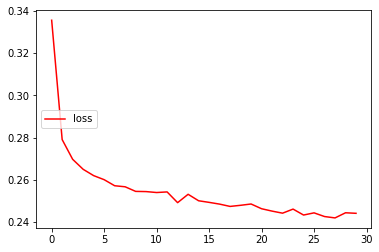

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(loss_trace, color='red', label='loss')
plt.legend(loc='center left')

# ax2 = ax1.twinx() 
# ax2.plot(accuracy_trace, color='blue', label='accuracy')
# plt.legend(loc='center right')

plt.show()

In [5]:
print(f'Test Period Accuracy : {accuracy_run}')

Test Period Accuracy : 0.9146999716758728


In [6]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 952    0    3    2    3    8    7    2    2    1]
 [   0 1119    4    2    0    1    3    1    5    0]
 [   9   16  896   22   10    3   10   10   52    4]
 [   4    1   14  929    4   19    2    9   23    5]
 [   1    3    7    6  930    0    4    4    6   21]
 [   6    3    3   39   10  744   13    4   64    6]
 [   7    3    7    2   12   32  888    1    6    0]
 [   1   13   17   14    7    2    0  932    4   38]
 [   6   15    3   26   13   23    5    9  859   15]
 [   7    8    2    8   46    9    0   20   11  898]]


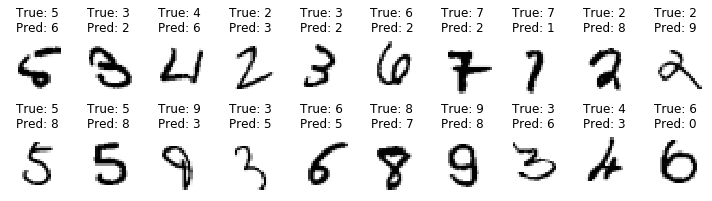

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 10, figsize=(10,3))

idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.binary)
            true_label = y_test_cls[idx]
            pred_label = y_test_cls_pred[idx]
            title = f'True: {true_label}\nPred: {pred_label}'
            ax.set_title(title)
            ax.axis('off')
            idx += 1
            break
            
plt.tight_layout()

plt.show()